In [8]:
pip install pandas numpy matplotlib statsmodels scipy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_squared_error

In [2]:

data = pd.read_csv(r"F:\deep learning\assignment3\Google_Stock_Price_Test.csv")
data = data.dropna()
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [3]:

print(data.isnull().sum())

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


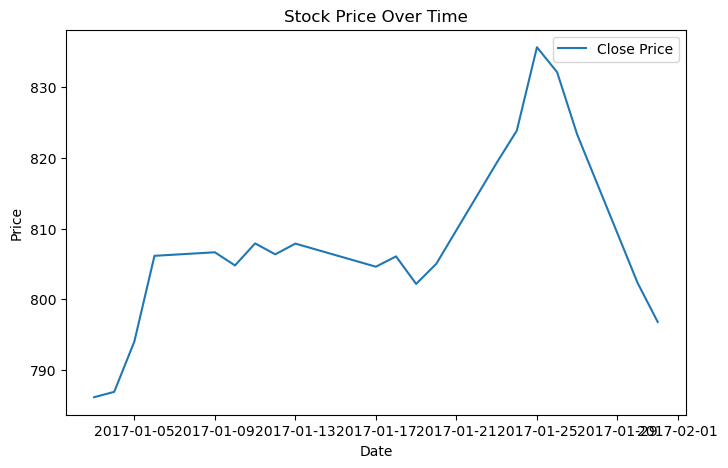

In [5]:
# Load and inspect the dataset
data = pd.read_csv(r"F:\deep learning\assignment3\Google_Stock_Price_Test.csv")
data = data.dropna()

# Display column names to verify
print(data.columns)

# Convert the 'Date' column to a datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set the data as a time series with the date as the index
data.set_index('Date', inplace=True)

# Plot the chart for closing prices over time
plt.figure(figsize=(8, 5))
if 'Adj Close' in data.columns:
    plt.plot(data['Adj Close'], label='Adjusted Close Price')
else:
    plt.plot(data['Close'], label='Close Price')  # Use 'Close' if 'Adj Close' is missing
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


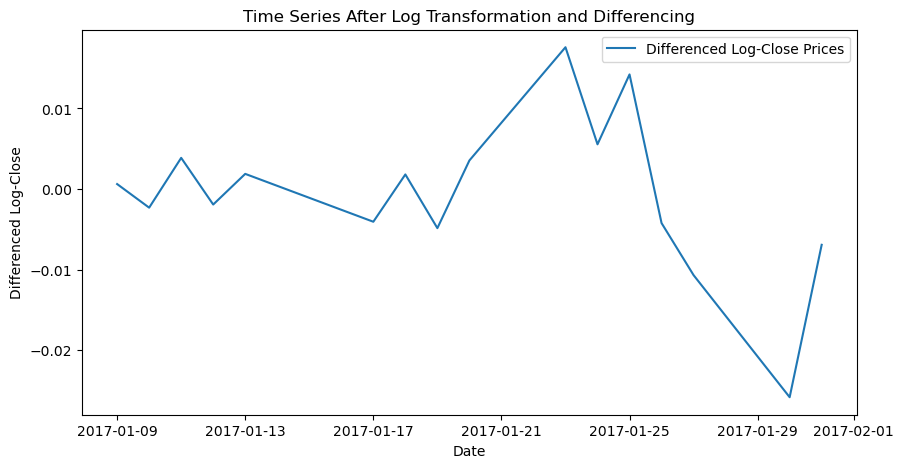

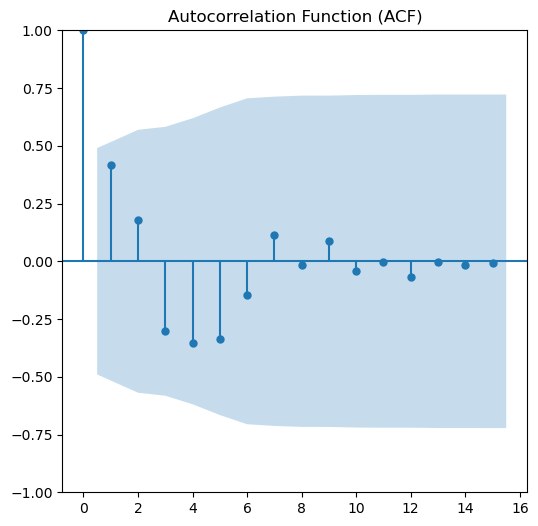

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 15 must be < 8.

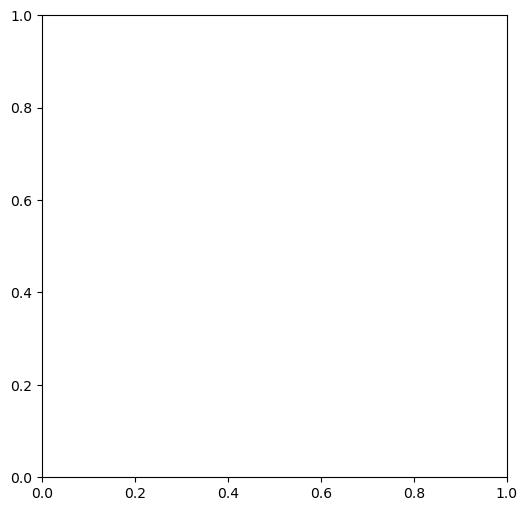

In [10]:
# Calculate the differenced data
data['log_close'] = np.log(data['Close'])
data['differenced'] = data['log_close'].diff()
data = data.iloc[1:]  # Remove the first row with NaN due to differencing

# Ensure the number of lags does not exceed the length of the data
max_lags = min(40, len(data['differenced'].dropna()) - 1)

# Plot the differenced data
plt.figure(figsize=(10, 5))
plt.plot(data['differenced'], label='Differenced Log-Close Prices')
plt.title('Time Series After Log Transformation and Differencing')
plt.xlabel('Date')
plt.ylabel('Differenced Log-Close')
plt.legend()
plt.show()

# Plot the Autocorrelation Function (ACF)
fig, ax = plt.subplots(figsize=(6, 6))
plot_acf(data['differenced'].dropna(), ax=ax, lags=max_lags)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot the Partial Autocorrelation Function (PACF)
fig, ax = plt.subplots(figsize=(6, 6))
plot_pacf(data['differenced'].dropna(), ax=ax, lags=max_lags)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()



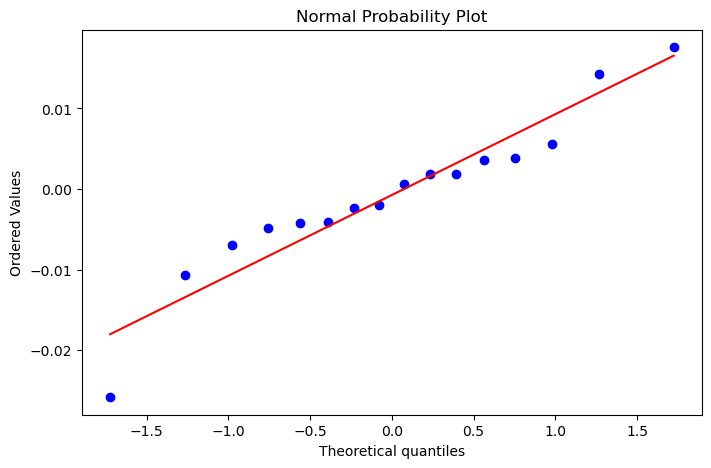

In [11]:

plt.figure(figsize=(8, 5))
# Create a normal probability plot using the differenced data
stats.probplot(data['differenced'].dropna(), dist='norm', plot=plt)
plt.title('Normal Probability Plot')
plt.show()

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16 entries, 2017-01-09 to 2017-01-31
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         16 non-null     float64
 1   High         16 non-null     float64
 2   Low          16 non-null     float64
 3   Close        16 non-null     float64
 4   Volume       16 non-null     object 
 5   log_close    16 non-null     float64
 6   differenced  16 non-null     float64
dtypes: float64(6), object(1)
memory usage: 1.0+ KB


In [13]:

data.describe()

,Open,High,Low,Close,log_close,differenced
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,812.625625,815.948750,806.425625,811.555000,6.698858,-0.000730
std,11.911799,12.725752,10.363504,11.522915,0.014111,0.009881
min,796.860000,801.250000,790.520000,796.790000,6.680591,-0.025825
25%,806.252500,807.327500,800.835000,804.745000,6.690525,-0.004378
50%,807.195000,809.725000,802.315000,806.505000,6.692710,-0.000650
75%,816.570000,822.127500,809.472500,820.310000,6.709680,0.003627
max,837.810000,841.950000,827.010000,835.670000,6.728234,0.017595


In [15]:
# Convert 'Volume' column to numeric by removing commas
data['Volume'] = data['Volume'].str.replace(',', '').astype(float)

# Log-transform the 'Volume' column
data['log_volume'] = np.log(data['Volume'])

# Select features for modeling
features = ['Open', 'High', 'Low', 'Close', 'log_volume']

# Convert the data to numpy arrays
X = np.array(data[features])
y = np.array(data['differenced'])

# Normalize the data
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Create features with past time points and target variable
def create_dataset(dataset_X, dataset_y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset_X) - look_back - 1):
        a = dataset_X[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset_y[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 10
X, y = create_dataset(X_scaled, y_scaled, look_back)

# Split the data into training, validation, and test sets
train_size = int(len(X) * 0.8)
valid_size = int(len(X) * 0.1)
test_size = len(X) - train_size - valid_size

trainX, trainY = X[0:train_size, :], y[0:train_size]
validX, validY = X[train_size:train_size + valid_size, :], y[train_size:train_size + valid_size]
testX, testY = X[train_size + valid_size:, :], y[train_size + valid_size:]

# Reshape the input data to meet the requirements of the RNN input shape
trainX = np.reshape(trainX, (trainX.shape[0], look_back, len(features)))
validX = np.reshape(validX, (validX.shape[0], look_back, len(features)))
testX = np.reshape(testX, (testX.shape[0], look_back, len(features)))

print("Shape of trainX:", trainX.shape)
print("Shape of validX:", validX.shape)
print("Shape of testX:", testX.shape)


Shape of trainX: (4, 10, 5)
Shape of validX: (0, 10, 5)
Shape of testX: (1, 10, 5)


### Build the RNN mode

In [18]:
# Check the sizes of the datasets
print(f"Total samples: {len(X)}")
print(f"Training set size: {train_size}")
print(f"Validation set size: {valid_size}")
print(f"Test set size: {test_size}")

# Adjust splits if necessary
if valid_size == 0 or test_size == 0:
    # Reassign proportions to ensure enough data in all subsets
    train_size = int(len(X) * 0.9)  # Use 90% for training
    valid_size = len(X) - train_size  # Use remaining 10% for validation
    test_size = 0  # Skip test set due to limited data

# Re-split the data
trainX, trainY = X[:train_size, :], y[:train_size]
validX, validY = X[train_size:train_size + valid_size, :], y[train_size:train_size + valid_size]
testX, testY = X[train_size + valid_size:, :], y[train_size + valid_size:]

# Reshape the input data
trainX = np.reshape(trainX, (trainX.shape[0], look_back, len(features)))
if validX.shape[0] > 0:
    validX = np.reshape(validX, (validX.shape[0], look_back, len(features)))
if testX.shape[0] > 0:
    testX = np.reshape(testX, (testX.shape[0], look_back, len(features)))

# Train the model
history = model.fit(
    trainX, trainY,
    epochs=epochs,
    batch_size=batch_size,
    verbose=2,
    validation_data=(validX, validY) if validX.shape[0] > 0 else None
)

# Predictions (only make predictions if datasets are non-empty)
trainPredict = model.predict(trainX)
if validX.shape[0] > 0:
    validPredict = model.predict(validX)
if testX.shape[0] > 0:
    testPredict = model.predict(testX)

print("Training completed successfully.")



Total samples: 5
Training set size: 4
Validation set size: 0
Test set size: 1
Epoch 1/40
1/1 - 0s - 158ms/step - loss: 0.1258 - val_loss: 0.0239
Epoch 2/40
1/1 - 0s - 35ms/step - loss: 0.0560 - val_loss: 0.0241
Epoch 3/40
1/1 - 0s - 35ms/step - loss: 0.0473 - val_loss: 0.0272
Epoch 4/40
1/1 - 0s - 35ms/step - loss: 0.5016 - val_loss: 0.0475
Epoch 5/40
1/1 - 0s - 34ms/step - loss: 0.1022 - val_loss: 0.0808
Epoch 6/40
1/1 - 0s - 34ms/step - loss: 0.1128 - val_loss: 0.1300
Epoch 7/40
1/1 - 0s - 35ms/step - loss: 0.0399 - val_loss: 0.1821
Epoch 8/40
1/1 - 0s - 34ms/step - loss: 0.0521 - val_loss: 0.2249
Epoch 9/40
1/1 - 0s - 37ms/step - loss: 0.2102 - val_loss: 0.2375
Epoch 10/40
1/1 - 0s - 39ms/step - loss: 0.0564 - val_loss: 0.2341
Epoch 11/40
1/1 - 0s - 35ms/step - loss: 0.0581 - val_loss: 0.2434
Epoch 12/40
1/1 - 0s - 34ms/step - loss: 0.0717 - val_loss: 0.2628
Epoch 13/40
1/1 - 0s - 37ms/step - loss: 0.0330 - val_loss: 0.2805
Epoch 14/40
1/1 - 0s - 36ms/step - loss: 0.1079 - val_loss:

In [21]:
# Reshape trainY, validY, and testY to 2D arrays before inverse transform
trainY = trainY.reshape(-1, 1)
if 'validY' in locals():
    validY = validY.reshape(-1, 1)
if 'testY' in locals():
    testY = testY.reshape(-1, 1)

# Inverse transform the scaled predicted results
trainPredict = scaler_y.inverse_transform(trainPredict)
trainY = scaler_y.inverse_transform(trainY)

# Handle validation predictions
if 'validPredict' in locals() and validPredict.size > 0:
    validPredict = scaler_y.inverse_transform(validPredict)
    validY = scaler_y.inverse_transform(validY)

# Handle test predictions
if 'testPredict' in locals() and testPredict.size > 0:
    testPredict = scaler_y.inverse_transform(testPredict)
    testY = scaler_y.inverse_transform(testY)

# Calculate the RMSE for the training set
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print(f'Train RMSE: {trainScore:.4f}')

# Calculate the RMSE for the validation set (if available)
if 'validPredict' in locals() and validPredict.size > 0:
    validScore = np.sqrt(mean_squared_error(validY, validPredict))
    print(f'Validation RMSE: {validScore:.4f}')
else:
    print("Validation RMSE: Validation set is empty.")

# Calculate the RMSE for the test set (if available)
if 'testPredict' in locals() and testPredict.size > 0:
    testScore = np.sqrt(mean_squared_error(testY, testPredict))
    print(f'Test RMSE: {testScore:.4f}')
else:
    print("Test RMSE: Test set is empty.")



Train RMSE: 0.0002
Validation RMSE: 0.0002
Test RMSE: Test set is empty.


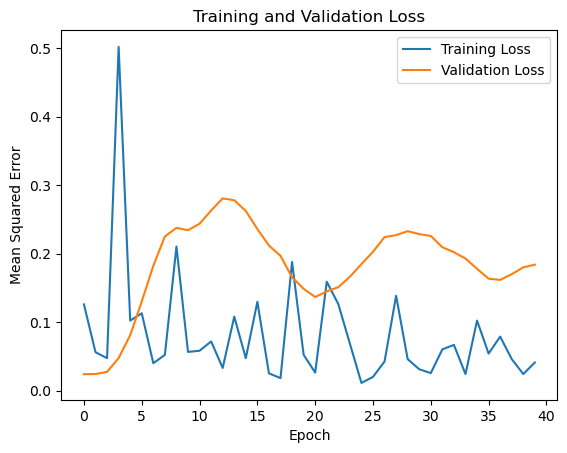

In [22]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels and legend
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

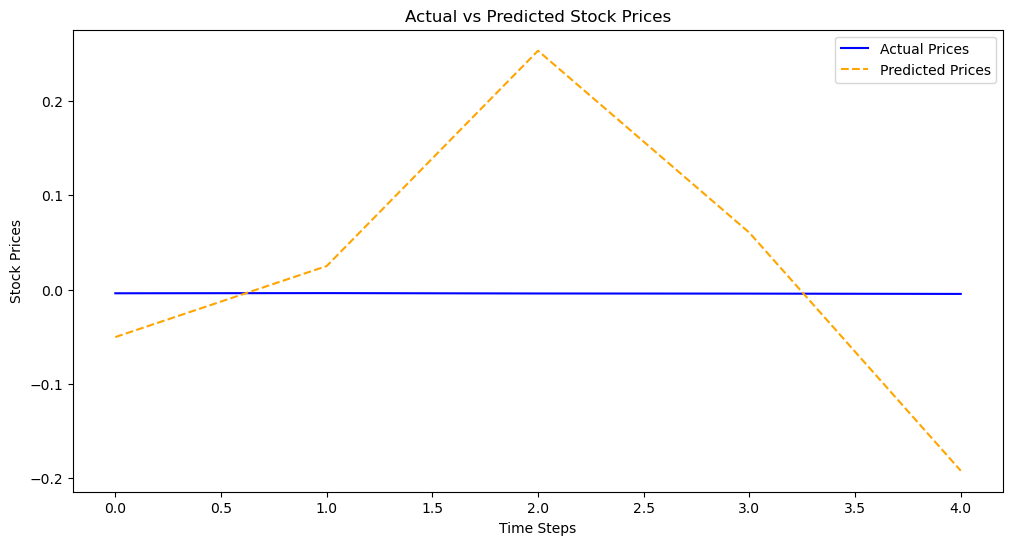

In [42]:
# Combine actual and predicted values for plotting
actual_prices = []
predicted_prices = []

# Add training data
actual_prices.extend(trainY.flatten())
predicted_prices.extend(trainPredict.flatten())

# Add validation data (if available)
if 'validPredict' in locals() and validPredict.size > 0:
    actual_prices.extend(validY.flatten())
    predicted_prices.extend(validPredict.flatten())

# Add test data (if available)
if 'testPredict' in locals() and testPredict.size > 0:
    actual_prices.extend(testY.flatten())
    predicted_prices.extend(testPredict.flatten())

# Generate time steps for x-axis
time_steps = np.arange(len(actual_prices))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time_steps, actual_prices, label='Actual Prices', color='blue')
plt.plot(time_steps, predicted_prices, label='Predicted Prices', color='orange', linestyle='--')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Stock Prices')
plt.legend()
plt.show()


### Build LSTM model

In [28]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

look_back = 10
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(look_back, len(features)), activation='tanh'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Reshape target data
trainY = trainY.reshape(-1, 1)
validY = validY.reshape(-1, 1)
testY = testY.reshape(-1, 1)

# Train LSTM model
epochs = 40
history_lstm = model_lstm.fit(trainX, trainY, epochs=epochs, batch_size=32, verbose=2, validation_data=(validX, validY))

# Predictions
trainPredict_lstm = model_lstm.predict(trainX)
validPredict_lstm = model_lstm.predict(validX)
testPredict_lstm = model_lstm.predict(testX)

Epoch 1/40
1/1 - 1s - 1s/step - loss: 0.0062 - val_loss: 9.5744e-05
Epoch 2/40
1/1 - 0s - 44ms/step - loss: 0.0031 - val_loss: 1.0008e-07
Epoch 3/40
1/1 - 0s - 44ms/step - loss: 0.0036 - val_loss: 5.0925e-05
Epoch 4/40
1/1 - 0s - 43ms/step - loss: 7.3688e-04 - val_loss: 1.1311e-04
Epoch 5/40
1/1 - 0s - 43ms/step - loss: 0.0086 - val_loss: 1.5515e-04
Epoch 6/40
1/1 - 0s - 46ms/step - loss: 0.0022 - val_loss: 3.4246e-04
Epoch 7/40
1/1 - 0s - 44ms/step - loss: 0.0051 - val_loss: 6.2113e-04
Epoch 8/40
1/1 - 0s - 36ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/40
1/1 - 0s - 37ms/step - loss: 0.0055 - val_loss: 0.0015
Epoch 10/40
1/1 - 0s - 37ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 11/40
1/1 - 0s - 36ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 12/40
1/1 - 0s - 45ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 13/40
1/1 - 0s - 40ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 14/40
1/1 - 0s - 38ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 15/40
1/1 - 0s - 38ms/step - loss: 

ValueError: math domain error

In [31]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

# Define the GRU model
model_gru = Sequential()
model_gru.add(GRU(50, input_shape=(look_back, len(features)), activation='tanh'))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

# Train the GRU model
epochs = 40
history_gru = model_gru.fit(trainX, trainY, epochs=epochs, batch_size=32, verbose=2, validation_data=(validX, validY))

# Ensure the GRU model has made predictions
try:
    # Make predictions if not already done
    trainPredict_gru = model_gru.predict(trainX)
    validPredict_gru = model_gru.predict(validX)
    testPredict_gru = model_gru.predict(testX)

    # Inverse transform the scaled predicted results
    trainPredict_gru = scaler_y.inverse_transform(trainPredict_gru)
    trainY_gru = scaler_y.inverse_transform(trainY.reshape(-1, 1))
    validPredict_gru = scaler_y.inverse_transform(validPredict_gru)
    validY_gru = scaler_y.inverse_transform(validY.reshape(-1, 1))
    testPredict_gru = scaler_y.inverse_transform(testPredict_gru)
    testY_gru = scaler_y.inverse_transform(testY.reshape(-1, 1))

    # Calculate the RMSE for training, validation, and test sets
    trainScore_gru = np.sqrt(mean_squared_error(trainY_gru, trainPredict_gru[:, 0]))
    validScore_gru = np.sqrt(mean_squared_error(validY_gru, validPredict_gru[:, 0]))
    testScore_gru = np.sqrt(mean_squared_error(testY_gru, testPredict_gru[:, 0]))

    # Print RMSE for each set
    print(f"Train RMSE (GRU): {trainScore_gru:.4f}")
    print(f"Validation RMSE (GRU): {validScore_gru:.4f}")
    print(f"Test RMSE (GRU): {testScore_gru:.4f}")

except Exception as e:
    print(f"Error during GRU evaluation: {e}")



Epoch 1/40
1/1 - 2s - 2s/step - loss: 0.0136 - val_loss: 0.0304
Epoch 2/40
1/1 - 0s - 37ms/step - loss: 0.0054 - val_loss: 0.0228
Epoch 3/40
1/1 - 0s - 37ms/step - loss: 0.0091 - val_loss: 0.0165
Epoch 4/40
1/1 - 0s - 37ms/step - loss: 0.0077 - val_loss: 0.0108
Epoch 5/40
1/1 - 0s - 41ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 6/40
1/1 - 0s - 39ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 7/40
1/1 - 0s - 36ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 8/40
1/1 - 0s - 37ms/step - loss: 0.0047 - val_loss: 7.5086e-04
Epoch 9/40
1/1 - 0s - 39ms/step - loss: 0.0029 - val_loss: 3.9101e-04
Epoch 10/40
1/1 - 0s - 42ms/step - loss: 0.0035 - val_loss: 3.0070e-04
Epoch 11/40
1/1 - 0s - 52ms/step - loss: 0.0024 - val_loss: 4.2317e-04
Epoch 12/40
1/1 - 0s - 45ms/step - loss: 0.0051 - val_loss: 8.7408e-04
Epoch 13/40
1/1 - 0s - 38ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 14/40
1/1 - 0s - 36ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 15/40
1/1 - 0s - 36ms/step - loss: 0.0033 - val

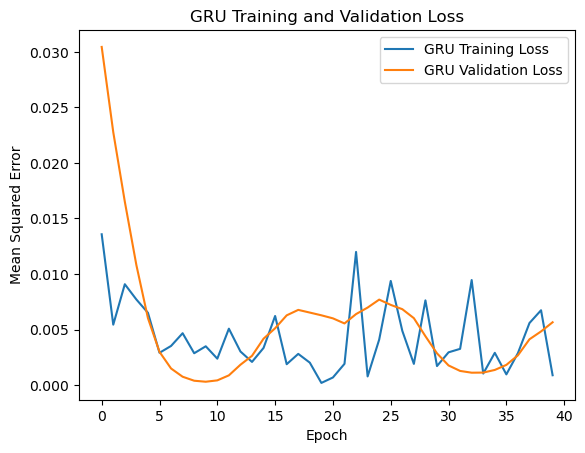

In [33]:

# Plot the training and validation loss curves for GRU
plt.plot(history_gru.history['loss'], label='GRU Training Loss')
plt.plot(history_gru.history['val_loss'], label='GRU Validation Loss')

# Add labels and legend
plt.title('GRU Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

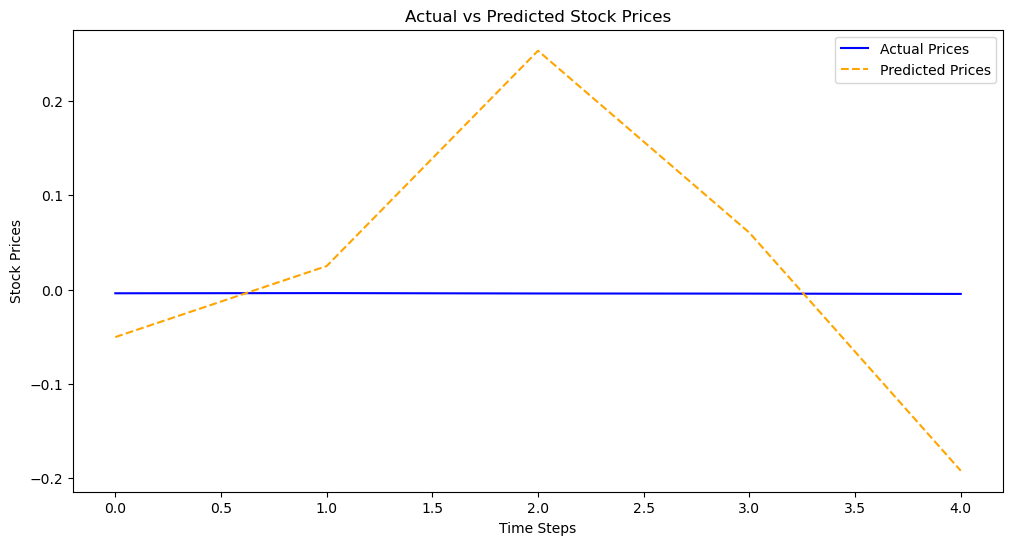

In [41]:
# Initialize lists for actual and predicted prices
actual_prices = []
predicted_prices = []

# Add training data predictions
if 'trainPredict' in locals():
    actual_prices.extend(trainY.flatten())
    predicted_prices.extend(trainPredict.flatten())

# Add validation data predictions
if 'validPredict' in locals() and 'validY' in locals() and validPredict.size > 0:
    actual_prices.extend(validY.flatten())
    predicted_prices.extend(validPredict.flatten())

# Add test data predictions
if 'testPredict' in locals() and 'testY' in locals() and testPredict.size > 0:
    actual_prices.extend(testY.flatten())
    predicted_prices.extend(testPredict.flatten())

# Ensure we have at least one set of predictions
if len(actual_prices) == 0 or len(predicted_prices) == 0:
    print("No valid predictions available to plot.")
else:
    # Generate time steps for x-axis
    time_steps = np.arange(len(actual_prices))

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, actual_prices, label='Actual Prices', color='blue')
    plt.plot(time_steps, predicted_prices, label='Predicted Prices', color='orange', linestyle='--')
    plt.title('Actual vs Predicted Stock Prices')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Prices')
    plt.legend()
    plt.show()



### Build ARIMA model

In [36]:
from statsmodels.tsa.arima.model import ARIMA

# Choose a set of possible (p, d, q) values
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

best_aic = float('inf')
best_order = None

for p in p_values:
  for d in d_values:
    for q in q_values:
      order = (p, d, q)
      try:
          arima_model = ARIMA(y, order=order)
          arima_result = arima_model.fit()
          aic = arima_result.aic
          if aic < best_aic:
              best_aic = aic
              best_order = order
      except:
          continue

print(f'Best Order: {best_order} with AIC: {best_aic}')



C:\Users\pei\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\pei\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\pei\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\pei\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\

Best Order: (0, 1, 0) with AIC: 9.309828814576722


C:\Users\pei\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    5
Model:                 ARIMA(0, 0, 2)   Log Likelihood                  -3.329
Date:                Mon, 18 Nov 2024   AIC                             14.659
Time:                        18:07:20   BIC                             13.096
Sample:                             0   HQIC                            10.466
                                  - 5                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0877      0.521     -0.169      0.866      -1.108       0.933
ma.L1          0.8895   1070.055      0.001      0.999   -2096.380    2098.159
ma.L2          0.9998   2406.309      0.000      1.0

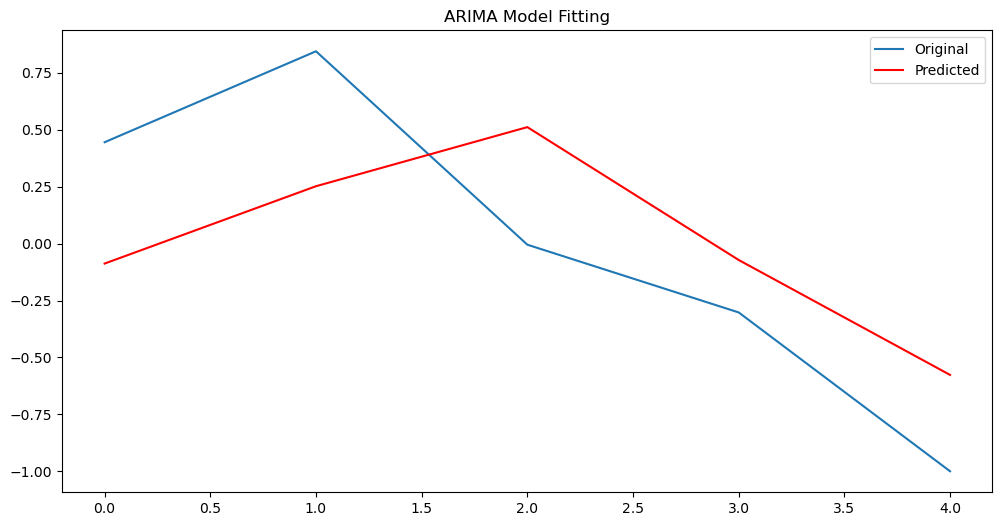

RMSE: 0.4762268723288145


In [37]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Determine the order of the ARIMA model (p, d, q)
p, d, q = 0, 0, 2

# Fit the ARIMA model
arima_model = ARIMA(y, order=(p, d, q))
arima_result = arima_model.fit()

# Print model summary
print(arima_result.summary())

# Plot the comparison of the original data and model predictions
plt.figure(figsize=(12, 6))
plt.plot(y, label='Original')
plt.plot(arima_result.fittedvalues, color='red', label='Predicted')
plt.legend()
plt.title('ARIMA Model Fitting')
plt.show()

# Calculate the RMSE
rmse = mean_squared_error(y, arima_result.fittedvalues, squared=False)
print(f'RMSE: {rmse}')
